In [3]:
!wget https://image-net.org/data/ILSVRC/2010/ILSVRC2010_images_val.tar

--2023-08-25 14:04:13--  https://image-net.org/data/ILSVRC/2010/ILSVRC2010_images_val.tar
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5397002240 (5.0G) [application/x-tar]
Saving to: ‘ILSVRC2010_images_val.tar’

ILSVRC2010_images_v 100%[===================>]   5.03G  29.3MB/s    in 2m 34s  

2023-08-25 14:06:48 (33.3 MB/s) - ‘ILSVRC2010_images_val.tar’ saved [5397002240/5397002240]



In [4]:
!tar xf ILSVRC2010_images_val.tar

In [5]:
import shutil
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

In [32]:
dataset_folder_name = 'dataset'

colors = []
color_path = []

if os.path.exists(dataset_folder_name):
  shutil.rmtree(dataset_folder_name)


for i in range(100):
  r = random.randint(0,255)
  g = random.randint(0,255)
  b = random.randint(0,255)
  colors.append((r,g,b))
  fold_name = str(i)
  fold_path = os.path.join(dataset_folder_name, fold_name)
  if os.path.exists(fold_path):
    continue
  os.makedirs(fold_path)
  color_path.append(fold_path)


h = w = 180
folder_name = 'val'

for file_name in os.listdir(folder_name)[:20000]:
  img = cv2.imread(os.path.join(folder_name, file_name))
  img = cv2.resize(img, (h,w))
  col = random.randint(0,99)
  img[:]= colors[col]
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2.imwrite(f'{os.path.join(color_path[col], file_name)}', rgb_img)



In [33]:
image_size = (h, w)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_folder_name,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
class_num = len(train_ds.class_names)
print(class_num)

Found 20000 files belonging to 100 classes.
Using 16000 files for training.
Using 4000 files for validation.
100


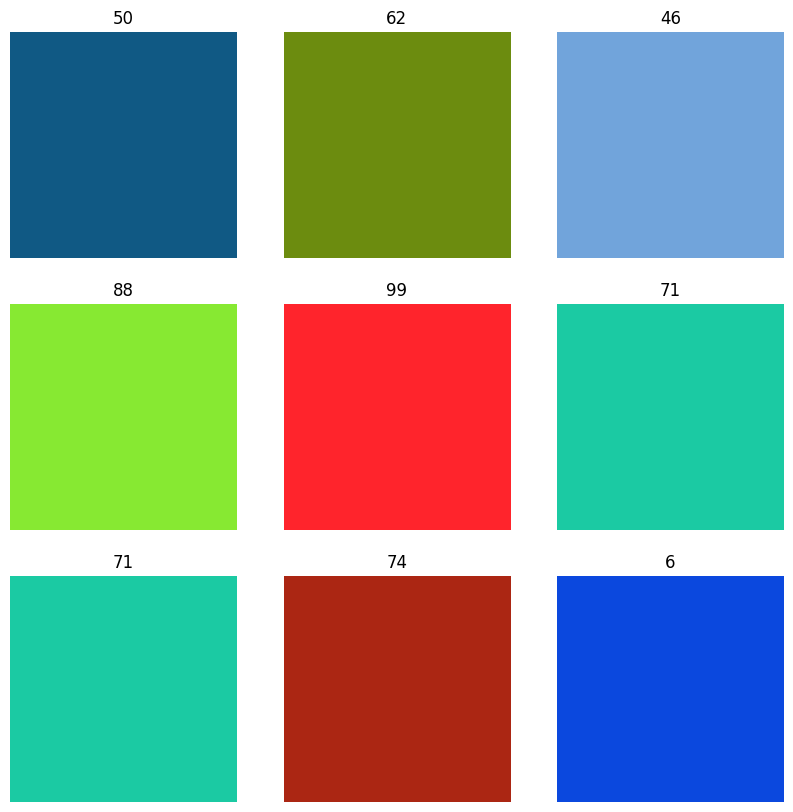

In [34]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [35]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

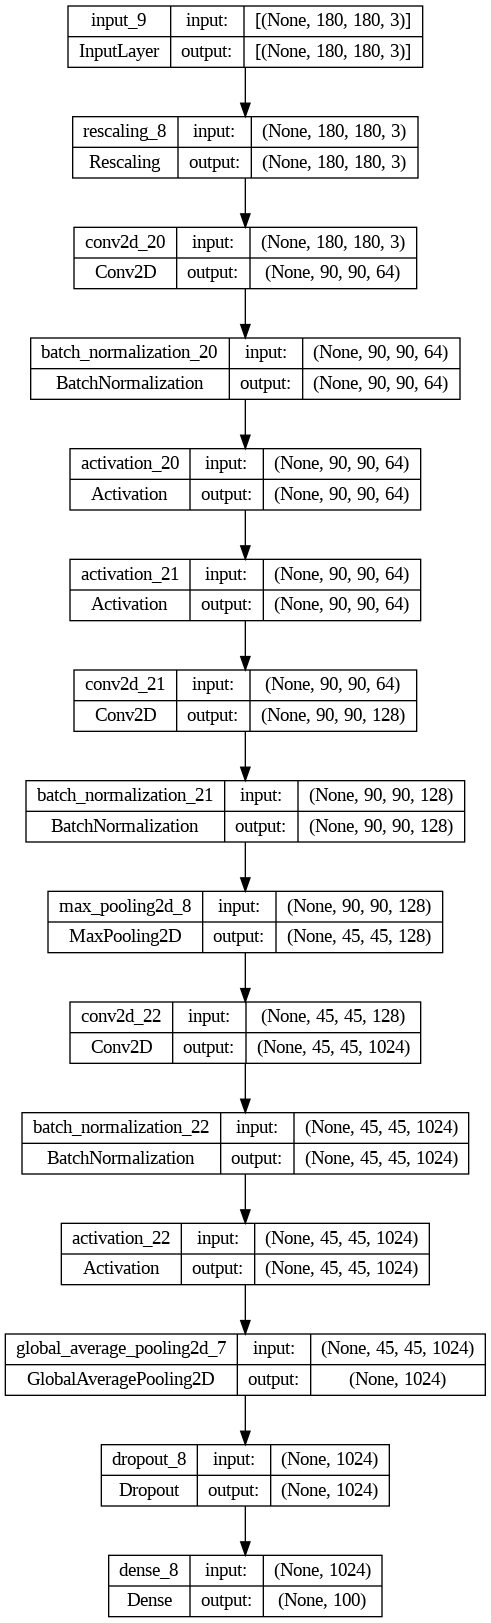

In [36]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.000 / 255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)


        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


    x = layers.Conv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=class_num)
keras.utils.plot_model(model, show_shapes=True)

In [37]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=3, verbose=1)
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/10
250/250 [==============================] - 72s 277ms/step - loss: 1.1762 - accuracy: 0.6164 - val_loss: 5.6156 - val_accuracy: 0.0728
Epoch 2/10
250/250 [==============================] - 70s 281ms/step - loss: 0.5691 - accuracy: 0.7919 - val_loss: 0.8260 - val_accuracy: 0.7060
Epoch 3/10
250/250 [==============================] - 71s 281ms/step - loss: 0.4695 - accuracy: 0.8237 - val_loss: 0.4336 - val_accuracy: 0.8077
Epoch 4/10
250/250 [==============================] - 70s 279ms/step - loss: 0.4079 - accuracy: 0.8436 - val_loss: 0.1584 - val_accuracy: 0.9283
Epoch 5/10
250/250 [==============================] - 70s 280ms/step - loss: 0.3789 - accuracy: 0.8536 - val_loss: 0.1884 - val_accuracy: 0.9107
Epoch 6/10
250/250 [==============================] - 70s 280ms/step - loss: 0.3862 - accuracy: 0.8532 - val_loss: 0.1169 - val_accuracy: 0.9507
Epoch 7/10
250/250 [==============================] - 70s 280ms/step - loss: 0.3384 - accuracy: 0.8674 - val_loss: 0.1978 - val_ac

# Adding Noise

In [42]:
dataset_folder_name = 'dataset'

colors = []
color_path = []

if os.path.exists(dataset_folder_name):
  shutil.rmtree(dataset_folder_name)


for i in range(100):
  r = random.randint(0,255)
  g = random.randint(0,255)
  b = random.randint(0,255)
  colors.append((r,g,b))
  fold_name = str(i)
  fold_path = os.path.join(dataset_folder_name, fold_name)
  if os.path.exists(fold_path):
    continue
  os.makedirs(fold_path)
  color_path.append(fold_path)


h = w = 180
folder_name = 'val'

for file_name in os.listdir(folder_name)[:20000]:
  img = cv2.imread(os.path.join(folder_name, file_name))

  img = cv2.resize(img, (h,w))


  col = random.randint(0,99)
  img[:]= colors[col]

  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mean = 0
  stddev = 180
  noise = np.zeros(img.shape, np.uint8)
  cv2.randn(noise, mean, stddev)
  noisy_img = cv2.add(rgb_img, noise)

  cv2.imwrite(f'{os.path.join(color_path[col], file_name)}', noisy_img)

In [43]:
image_size = (h, w)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_folder_name,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
class_num = len(train_ds.class_names)
print(class_num)

Found 20000 files belonging to 100 classes.
Using 16000 files for training.
Using 4000 files for validation.
100


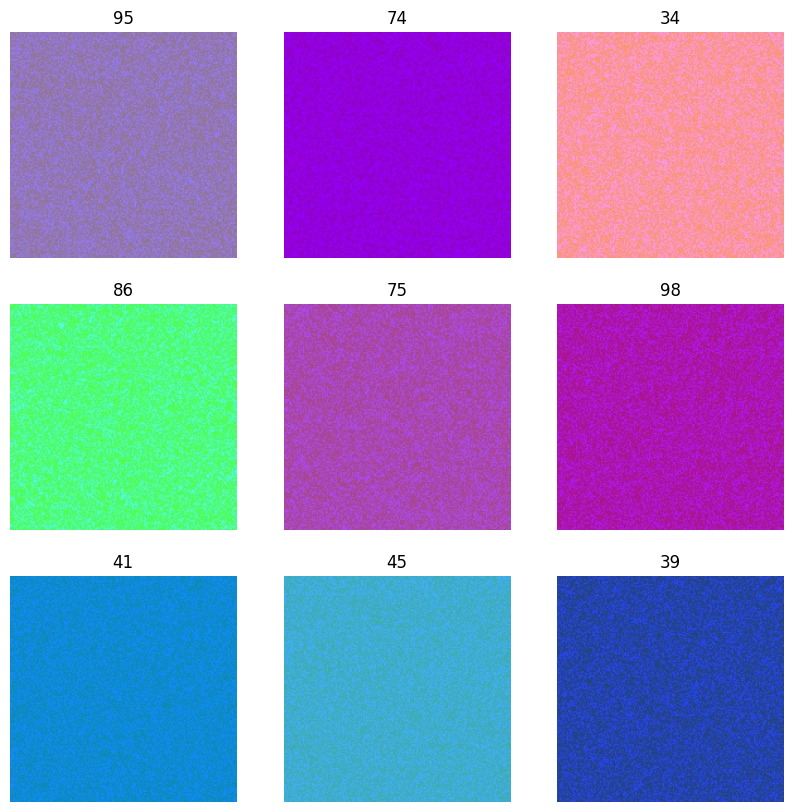

In [46]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [47]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

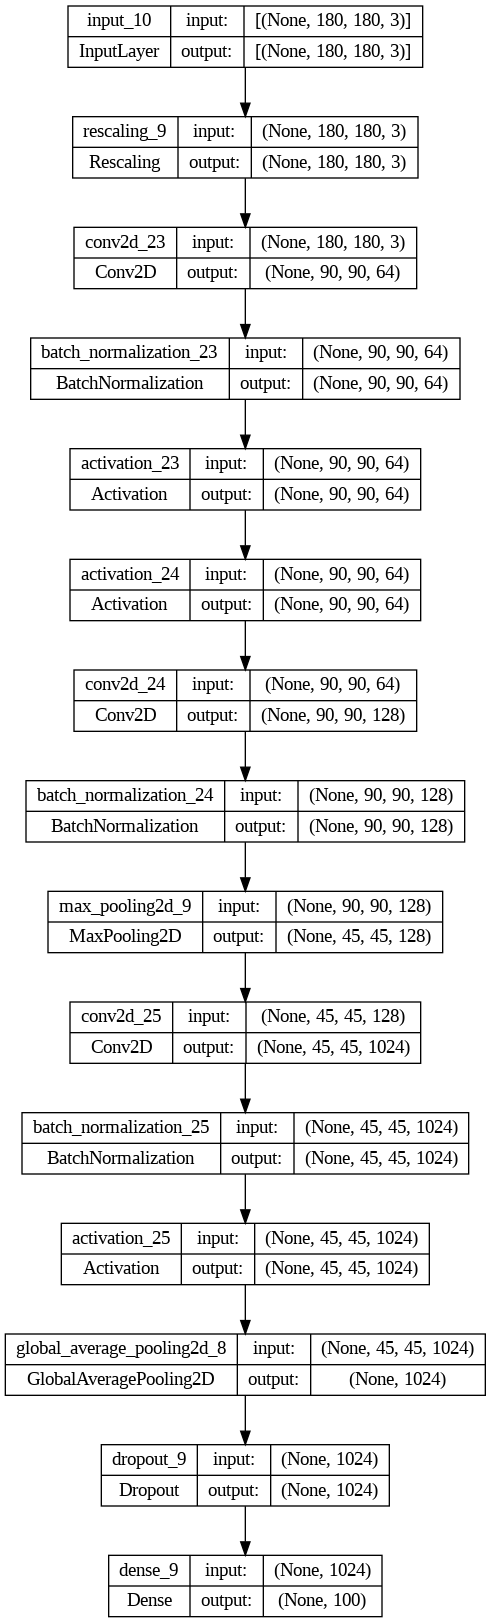

In [48]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.000 / 255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)


        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


    x = layers.Conv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=class_num)
keras.utils.plot_model(model, show_shapes=True)

In [49]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=3, verbose=1)
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/10
250/250 [==============================] - 76s 289ms/step - loss: 1.2056 - accuracy: 0.6061 - val_loss: 7.1864 - val_accuracy: 0.0545
Epoch 2/10
250/250 [==============================] - 73s 289ms/step - loss: 0.5778 - accuracy: 0.7819 - val_loss: 0.6147 - val_accuracy: 0.7887
Epoch 3/10
250/250 [==============================] - 72s 289ms/step - loss: 0.4651 - accuracy: 0.8241 - val_loss: 1.4774 - val_accuracy: 0.6555
Epoch 4/10
250/250 [==============================] - 73s 290ms/step - loss: 0.3919 - accuracy: 0.8469 - val_loss: 0.2594 - val_accuracy: 0.9040
Epoch 5/10
250/250 [==============================] - 73s 289ms/step - loss: 0.3539 - accuracy: 0.8654 - val_loss: 0.1406 - val_accuracy: 0.9490
Epoch 6/10
250/250 [==============================] - 78s 310ms/step - loss: 0.3414 - accuracy: 0.8666 - val_loss: 0.1876 - val_accuracy: 0.9220
Epoch 7/10
250/250 [==============================] - 73s 289ms/step - loss: 0.3411 - accuracy: 0.8695 - val_loss: 0.1535 - val_ac

# Adding Stronger noise

In [23]:
dataset_folder_name = 'dataset'

colors = []
color_path = []

if os.path.exists(dataset_folder_name):
  shutil.rmtree(dataset_folder_name)

for i in range(100):
  r = random.randint(0,255)
  g = random.randint(0,255)
  b = random.randint(0,255)
  colors.append((r,g,b))
  fold_name = str(i)
  fold_path = os.path.join(dataset_folder_name, fold_name)

  if os.path.exists(fold_path):
    continue
  os.makedirs(fold_path)
  color_path.append(fold_path)

h = w = 180
folder_name = 'val'

for file_name in os.listdir(folder_name)[:20000]:
  img = cv2.imread(os.path.join(folder_name, file_name))

  img = cv2.resize(img, (h,w))
  col = random.randint(0,99)
  img[:]= colors[col]
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # each for loop corresponds to different number of noises applied to images

  # for i in range(1800):
  #   rgb_img[random.sample(range(0, 179), 1), random.sample(range(0, 179), 1)] = (0,0,0)

  for i in range(6480):
    rgb_img[random.sample(range(0, 179), 1), random.sample(range(0, 179), 1)] = (0,0,0)

  cv2.imwrite(f'{os.path.join(color_path[col], file_name)}', rgb_img)

In [24]:
image_size = (h, w)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_folder_name,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
class_num = len(train_ds.class_names)

Found 20000 files belonging to 100 classes.
Using 16000 files for training.
Using 4000 files for validation.


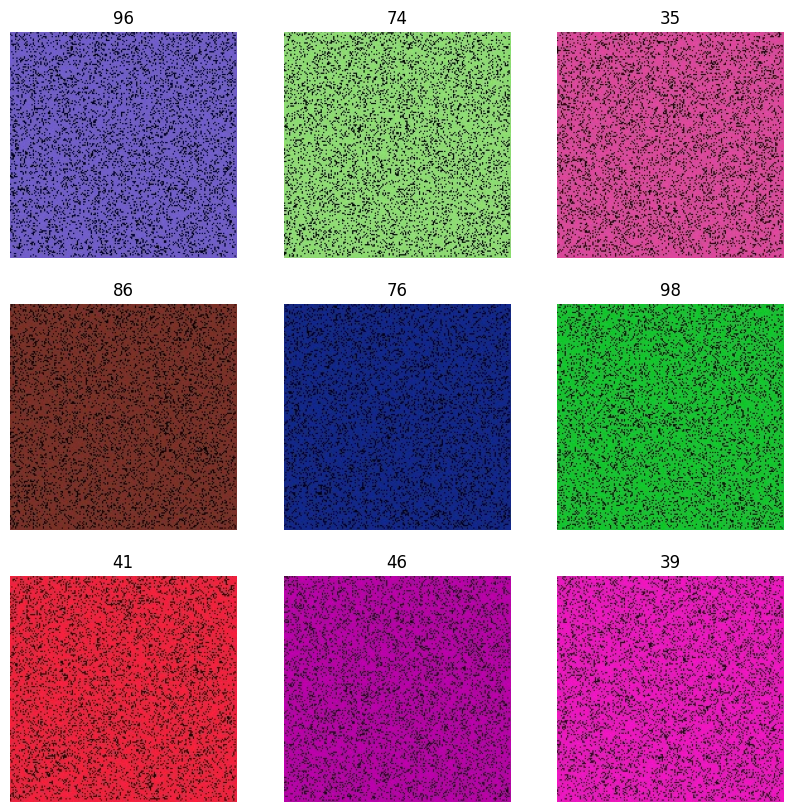

In [25]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [26]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

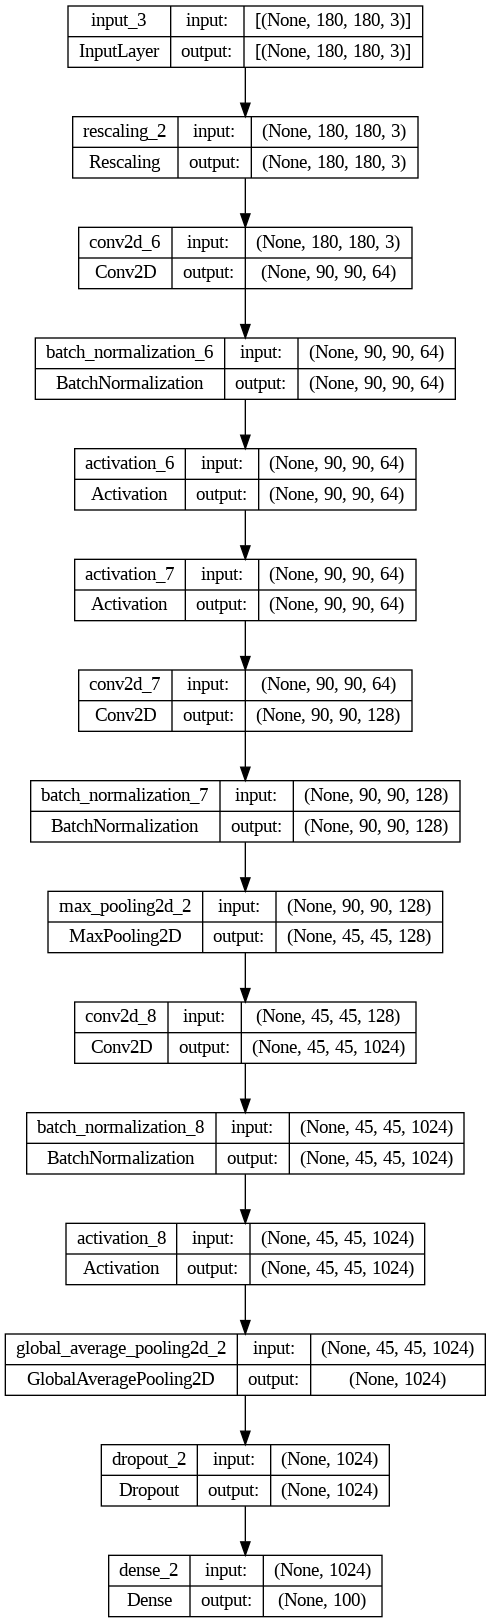

In [27]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.000 / 255)(inputs)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)


        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)


    x = layers.Conv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=class_num)
keras.utils.plot_model(model, show_shapes=True)

In [28]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(patience=3, verbose=1)
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/10
250/250 [==============================] - 80s 308ms/step - loss: 1.2653 - accuracy: 0.5899 - val_loss: 9.0264 - val_accuracy: 0.0290
Epoch 2/10
250/250 [==============================] - 75s 298ms/step - loss: 0.5671 - accuracy: 0.7883 - val_loss: 0.4920 - val_accuracy: 0.8145
Epoch 3/10
250/250 [==============================] - 75s 297ms/step - loss: 0.4261 - accuracy: 0.8432 - val_loss: 0.1952 - val_accuracy: 0.9202
Epoch 4/10
250/250 [==============================] - 75s 297ms/step - loss: 0.3817 - accuracy: 0.8547 - val_loss: 0.1445 - val_accuracy: 0.9460
Epoch 5/10
250/250 [==============================] - 74s 296ms/step - loss: 0.3174 - accuracy: 0.8772 - val_loss: 0.1052 - val_accuracy: 0.9517
Epoch 6/10
250/250 [==============================] - 74s 296ms/step - loss: 0.2743 - accuracy: 0.8941 - val_loss: 0.0879 - val_accuracy: 0.9833
Epoch 7/10
250/250 [==============================] - 75s 297ms/step - loss: 0.2911 - accuracy: 0.8904 - val_loss: 0.3526 - val_ac